# **DCDC Práctica Final: Predicción de Stock<a id="top"></a>**

<i><small>**Alumnos:** Che Cui y Alejandro Pequeño<br>Última actualización: 15/01/2024</small></i></div>

Análisis y predicción de series de temporales de sotck basadas en noticias para la asignatura de Descubrimineto de Conocimiento en Datos Complejos

---

**Índice:**

- [Imports](#-Imports)


- [1. Dataset](##-1.-Dataset)
  - [1.1 Carga y visualización](###-1.1-Carga-y-visualización)
  - [1.2 Preprocesado](###-1.2-Preprocesado)

<lr>

- [2. Análisis del DataFrame](##-2.-Análisis-del-DataFrame)
  - [2.1 Descomposición de la serie temporal](###-2.1-Descomposición-de-la-serie-temporal)
  - [2.2 Prueba de Dickey-Fuller](###-2.2-Prueba-de-Dickey-Fuller)
  - [2.3 Análisis de la autocorrelación](###-2.3-Análisis-de-la-autocorrelación)

<lr>

- [3. Métodos de Predicción](#-3.-Métodos-de-Predicción)
  - [3.0 AR, MA, ARMA](###-3.1-AR,-MA,-ARMA)
  - [3.1 ARIMA](###-3.1-ARIMA)
  - [3.2 SARIMA](###-3.2-SARIMA)
  - [3.3 SARIMAX](###-3.3-SARIMAX)

<lr>


## Imports

In [16]:
# Imports
# =====================================================================
!pip install statsmodels
!pip install pandas-datareader
!pip install yfinance
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import yfinance as yfin
import sklearn.preprocessing as preprocessing
import warnings
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import scipy.stats
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.filters.hp_filter import hpfilter
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.statespace.sarimax import SARIMAX

## 1. Dataset

### 1.1 Carga y visualización

El dataset proviene de Kaggle. En ella contiene alrededor de 41500 noticias francesas que van desde 2017-10-19 hasta 2021-03-19. Son scrapeado en paginas webs de noticias financieras famosas.

In [17]:
# Abrimos el archivo en formato pandas Dataframe
# =====================================================================

# Vía local ======
news_french = pd.read_csv("./data/FrenchNews.csv", parse_dates=True,  sep=',') # lectura y preprocesado de datos

# Visualización de los datos
news_french # versión tabular

,Numero news,Numero page,Numero,Date,Heure,Titre,Contenu,Agency,URL,textURL,Nbr image,seconds to 2010,days to 2010,dateDT,Title eng,Content eng,textURL eng,Sentiment Vader Title,Sentiment Vader Text,Sentiment Vader TextURL
0,1,2127,18,19.10.2017,08:57,Marseille : une baleine de 15 mètres piégée da...,C'est une drôle de découverte qu'ont faite ce ...,Le Point,https://www.boursorama.com/actualite-economiqu...,C'est une drôle de découverte qu'ont faite ce ...,0,246099420.0,2848.372917,2017-10-19 08:57:00,Marseille: a 15 metre whale trapped in the Old...,This is a strange discovery that the Marseilla...,It's a strange discovery that the Marseillais ...,-0.5267,0.3612,0.8689
1,2,2127,17,19.10.2017,10:35,"Le Burkinabé qui a stoppé le désert, l'intox d...",L'émission de cette semaine nous emmène au Bur...,France 24,https://www.boursorama.com/videos/actualites/l...,L'émission de cette semaine nous emmène au Bur...,0,246105300.0,2848.440972,2017-10-19 10:35:00,"The Burkinabe who stopped the desert, the into...",This week's show takes us to Burkina Faso to m...,This week's show takes us to Burkina Faso to m...,-0.2263,-0.6486,-0.1531
2,3,2127,16,19.10.2017,10:59,"En Grande-Bretagne, les ventes au détail subis...",LONDRES (Reuters) - Les ventes au détail en Gr...,Reuters,https://www.boursorama.com/actualite-economiqu...,LONDRES (Reuters) - Les ventes au détail en Gr...,1,246106740.0,2848.457639,2017-10-19 10:59:00,"In Great Britain, retail sales stopped in Sept...",LONDON (Reuters) - Retail sales in Great Brita...,LONDON (Reuters) - Retail sales in Great Brita...,0.4939,0.3182,-0.4019
3,4,2127,15,19.10.2017,11:40,Antiterrorisme : Bruxelles fait avec les moyen...,La sécurité ne fait pas partie des prérogative...,Le Point,https://www.boursorama.com/actualite-economiqu...,La sécurité ne fait pas partie des prérogative...,0,246109200.0,2848.486111,2017-10-19 11:40:00,Anti-terrorism: Brussels made with the means o...,Security is not part of the European Union's p...,Security is not part of the European Union's p...,0.0000,0.3400,-0.9748
4,5,2127,14,19.10.2017,11:58,"Dmitri Rybolovlev, président de l'AS Monaco, i...","NICE (Reuters) - Le président de l'AS Monaco, ...",Reuters,https://www.boursorama.com/actualite-economiqu...,"NICE (Reuters) - Le président de l'AS Monaco, ...",1,246110280.0,2848.498611,2017-10-19 11:58:00,"Dmitri Rybolovlev, President of AS Monaco, cha...","NICE (Reuters) - The president of AS Monaco, D...","NICE (Reuters) - The president of AS Monaco, D...",-0.2023,-0.3954,0.9386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41538,41539,2,5,19.03.2021,08:44,Chine: des véhicules de police arrivent au tri...,Des véhicules de police aux vitres teintées ce...,AFP Video,https://www.boursorama.com/videos/actualites/c...,Des véhicules de police aux vitres teintées ce...,0,353839440.0,4095.363889,2021-03-19 08:44:00,"China: Police vehicles arrive in court, Canadi...",Police vehicles with tinted windows supposed t...,Police vehicles with tinted windows supposed t...,0.0000,-0.8807,-0.8807
41539,41540,2,4,19.03.2021,08:45,Des voitures de police quittent le tribunal ch...,Des voitures de police qui transporteraient le...,AFP Video,https://www.boursorama.com/videos/actualites/d...,Des voitures de police qui transporteraient le...,0,353839500.0,4095.364583,2021-03-19 08:45:00,Police cars leave the Chinese court while the ...,Police cars transporting the Canadian on charg...,Police cars that would transport the Canadian ...,-0.0516,-0.3182,-0.3182
41540,41541,2,3,19.03.2021,08:49,Confinement: les coiffeurs pourront rester ou...,Les coiffeurs dans les zones concernées par un...,AFP,https://www.boursorama.com/actualite-economiqu...,Les coiffeurs dans les zones concernées par un...,0,353839740.0,4095.367361,2021-03-19 08:49:00,"Confection: hairdressers can stay open, says G...",The hairdressers in the areas affected by a ne...,"In the area concerned by a new confinement, th...",0.0000,0.3612,0.7558
41541,4

Como se puede observar a simple vista, el dataset contiene 20 columnas, de las cuales solo nos interesan las columnas de fecha y noticias con el fin de realizar un análisis de series temporales. Para ello, pasamos a preprocesar el dataset.

### 1.2 Preprocesado

#### 1.2.1 Preprocesado de los datos del dataset

**Selección de columnas:** Elegimos las columnas de fecha y el contenido de las noticias. Con esto, podemos hacer un análisis de sentimiento de las noticias y ver si hay alguna correlación con el precio de las acciones.

In [18]:
# Seleccionamos las clomnas de fecha y contenido de la noticia
news = news_french[['Date', 'Contenu']].copy()
news['Date'] = pd.to_datetime(news['Date'], format='%d.%m.%Y') # pasamos las fechas a formato datetime

# renombramos las columnas para que sean más faciles de manejar
news.rename(columns={'Contenu': 'headline', 'Date': 'date'}, inplace=True)

**Comprobación de valores nulos**: Comprobamos si hay valores nulos en las columnas seleccionadas. En este caso, no observamos que para las fechas no haya ningún valor nulo, pero para el contenido de las noticias sí que hay 65 valores nulos. Por ello, al tener 41543 noticias, decidimos eliminar las 65 noticias que no tienen contenido.

In [19]:
# Comprobación de valores nulos
news.isnull().sum()

date         0
headline    65
dtype: int64

In [20]:
# Eliminamos los valores nulos del dataset (aunque lo hagamos globalmente solo afectará a la columna de headline ya que es la única que tiene valores nulos)
news.dropna(inplace=True)

#### 1.2.2 Prepraración de los datos de stock

Con la ayuda de las librería de pandas-datareader e yfinance, es posible saca de manera facil desde Yahoo Finance los datos de los stock de manera facil y sencilla.

In [22]:
# la fecha mínima y máxima de las noticias
min_date = news.date.min()
max_date = news.date.max()

# =====================================================================
# resta 50 días a la fecha mínima( es importante ya que al predecir con las 25 fechas anteriores, necesitas esas 50 días de margen)
min_date = min_date - pd.DateOffset(days=50)
# suma 50 días a la fecha máxima
max_date = max_date + pd.DateOffset(days=50)

# convertimos las fechas a string
min_date = min_date.strftime('%Y-%m-%d')
max_date = max_date.strftime('%Y-%m-%d')

In [25]:
yfin.pdr_override()
# datos del índice europeo
euro = pdr.get_data_yahoo('^STOXX50E', start=min_date, end=max_date)
# datos del índice francés
french = pdr.get_data_yahoo('^FCHI', start=min_date, end=max_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [26]:
# datos del índice europeo
display(euro)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-08-30,3405.649902,3412.260010,3397.270020,3403.709961,3403.709961,23814000
2017-08-31,3409.620117,3437.820068,3409.620117,3421.469971,3421.469971,34738100
2017-09-01,3425.840088,3454.550049,3425.840088,3443.879883,3443.879883,26540900
2017-09-04,3436.360107,3438.060059,3419.060059,3430.419922,3430.419922,17726400
2017-09-05,3432.550049,3448.929932,3415.979980,3420.860107,3420.860107,27881800
...,...,...,...,...,...,...
2021-05-03,3979.500000,4009.729980,3965.500000,4000.250000,4000.250000,20815100
2021-05-04,4001.129883,4018.139893,3919.459961,3924.800049,3924.800049,35163600
2021-05-05,3927.290039,4003.090088,3927.290039,4002.790039,4002.790039,30131400


In [27]:
# datos del índice francés
display(french)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-08-30,5063.240234,5069.120117,5046.069824,5056.339844,5056.339844,61690100
2017-08-31,5083.120117,5104.779785,5068.439941,5085.589844,5085.589844,108192000
2017-09-01,5117.189941,5138.419922,5115.950195,5123.259766,5123.259766,75774600
2017-09-04,5088.279785,5114.700195,5088.279785,5103.970215,5103.970215,44171300
2017-09-05,5107.189941,5125.799805,5081.080078,5086.560059,5086.560059,72150200
...,...,...,...,...,...,...
2021-05-03,6285.509766,6314.919922,6252.660156,6307.899902,6307.899902,49980000
2021-05-04,6319.490234,6355.870117,6238.790039,6251.750000,6251.750000,85369200
2021-05-05,6284.540039,6339.470215,6275.140137,6339.470215,6339.470215,83862000


In [29]:
# solo nos interesa predecir el valor de apertura
euro_open = euro[['Open']].copy()

# reseteamos el índice
euro_open.reset_index(inplace=True)

# normalizamos los datos para que estén entre 0 y 1
min_max_scaler = preprocessing.MinMaxScaler()
euro_open['Open'] = min_max_scaler.fit_transform(euro_open['Open'].values.reshape(-1,1))

# datos final
euro_open

,Date,Open
0,2017-08-30,0.618192
1,2017-08-31,0.620606
2,2017-09-01,0.630469
3,2017-09-04,0.636865
4,2017-09-05,0.634548
...,...,...
919,2021-05-03,0.967111
920,2021-05-04,0.980263
921,2021-05-05,0.935366
922,2021-05-06,0.978178


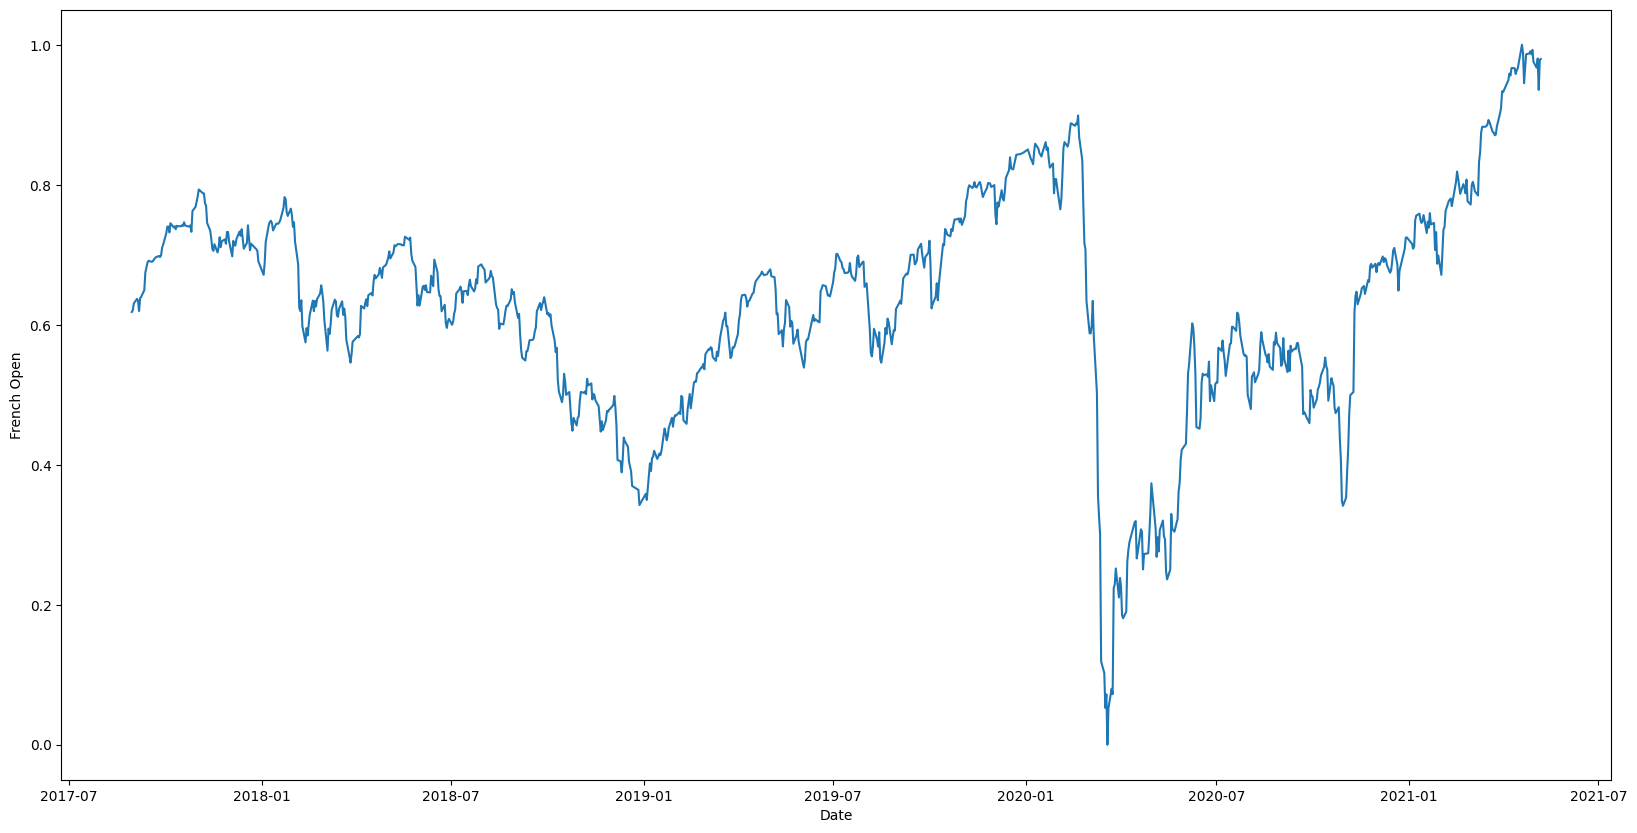

In [30]:
# plot euro open using the date as x-axis
plt.figure(figsize=(20,10))
plt.plot(euro_open['Date'], euro_open['Open'])
plt.xlabel('Date')
plt.ylabel('French Open')
plt.savefig('euro_open.png')
plt.show()

## 2. Análisis del DataFrame

### 2.1 Descomposición de la serie temporal

1. **Descomposición Aditiva**:
   - Los datos originales se descomponen en componentes aditivos, que incluyen tendencia, estacionalidad y residuos.
   - Los residuos del modelo aditivo muestran patrones que se suman de manera constante. Si estos residuos aumentan con el tiempo, esto podría indicar una tendencia creciente en la variabilidad de los datos.

2. **Descomposición Multiplicativa**:
   - Los datos originales se descomponen en componentes multiplicativos, que también incluyen tendencia, estacionalidad y residuos.
   - Elmodelo multiplicativo, los residuos son más constantes, y cualquier patrón de aumento se vería como una variabilidad proporcional. Un aumento constante en los residuos podría sugerir un aumento constante en la variabilidad relativa a la tendencia y la estacionalidad.

**Conclusión:**
- En la serie temporal los residuos aumentan de manera aditiva, mientras que en el enfoque multiplicativo los residuos se mantienen constantes, se podría concluir que la serie es más probablemente multiplicativa. Sin embargo, es importante realizar pruebas y validar el modelo para confirmar la elección del enfoque.

In [ ]:
# Descomposición de la serie temporal
# =====================================================================

# Aditiva
result = seasonal_decompose(df, model='additive', period = 30)
result.plot()
plt.show()

# Multiplicativa
result = seasonal_decompose(df, model='multiplicative', period = 30)
result.plot()
plt.show()

### 2.2 Prueba de Dickey-Fuller

Como podemos observar, tras la prueba de dickey-fuller, la serie no se puede decir que es estacionaria. Esto lo podemos deducir del valor del estadístico de prueba (ADF estadístico) y el p-valor junto con la comparación de estos valores con los valores críticos. En este caso, el valor del estadístico de prueba es positivo (0.8153688792060498) y mayor que los valores críticos en diferentes niveles de significación (1%, 5%, 10%). Además, el valor p es alto (0.991880243437641), lo que indica que no podemos rechazar la hipótesis nula de que la serie no es estacionaria.

En resumen, la serie temporal no es estacionaria según los resultados de la prueba de Dickey-Fuller.

In [ ]:
# Prueba de dickey-fuller
# =====================================================================
sts.adfuller(df.Passengers) # p-value > 0.05, no se puede rechazar la hipótesis nula de que la serie temporal no es estacionaria

Debido a la no estacionalidad de los valores de la serie, probamos a hacer su integración para representar la serie de una manera de variación porcentual con respecto a los días anteriores, lo cual puede dar un análisis más completo y para ver si podemos conseguir por lo menos que esta parte sea estacionaria para poder hacer un mejor estudio de la serie, pues la estacionalidad de una serie (media y desviación típica constantes) hará que podamos hacer un mejor análisis de esta, pues existirá una relación directa (autocorrelación, dependencia) entre los elementos futuros de la serie con los elementos pasados, además de que los errores son prácticamente cte. y, por tanto, previsibles.

La prueba de Dickey-Fuller con los retornos de la serie, los resultados de la prueba de Dickey-Fuller sugieren que es estacionaria, ya que el p valor es menor que 0.05 y el estadístico de prueba es negativo y menor que los valores críticos en el nivel de significación del 5% (aunque mayor que el 1%).

In [ ]:
# Calculamos los retornos del dataset y hacemos también la prueba de dickey-fuller
# =====================================================================
df['Returns'] = df.Passengers.pct_change(1).mul(100) # returns in percentage (variación porcentual con respecto al mes anterior)
sts.adfuller(df.Returns[1:]) # p-value < 0.05, se rechaza la hipótesis nula de que la serie temporal no es estacionaria

### 2.3 Análisis de la autocorrelación

En ambos casos, optaremos por seleccionar un rezago temporal (lag) de 24 unidades, dado que al abordar el número de pasajeros por mes, la consideración de un período de análisis de 2 años (24 meses) puede conferir mayor representatividad a la serie temporal.

- Mediante el análisis de autocorrelación de la serie de pasajeros, se aprecia que, a nivel global (ACF), la influencia preponderante en el número de pasajeros de un mes específico proviene del mes inmediatamente anterior. Aunque se puede observar un patrón sugerente de 12 meses, reflejado en la evolución de la autocorrelación a lo largo de los 24 lags, indicando que la serie podría estar influenciada significativamente por los últimos 12 meses. Por otro lado, en el análisis a nivel parcial (PACF), revela que la serie se ve afectada tanto por el mes anterior como por el mes del año anterior, es decir, el mes 12.

  Por ejemplo, el ACF y el PACF indican que el número de pasajeros en un mes determinado se encuentra influido tanto por el mes precedente como por el mismo mes del año anterior (mes 12).

In [ ]:
# Análisis de la autocorrelación de los pasajeros mensuales
# =====================================================================
def plot_acf_pacf(df, lags, title):
    fig, ax = plt.subplots(2,1,figsize=(12,8))
    plt.suptitle(title, fontsize=16)
    sgt.plot_acf(df, lags = lags, ax=ax[0]) # autocorrelación
    sgt.plot_pacf(df, lags = lags, ax=ax[1]) # autocorrelación parcial
    plt.show()


plot_acf_pacf(df.Passengers,lags=24, title='Monthly Air Passengers from 1949 to 1960.')

- El análisis de autocorrelación para los retornos de los pasajeros muestra algo similar al de los pasajeros, pero más marcado, indicando que la serie se ve influencia por los valores de los 12 y 24 últimos meses y a nivel parcial solo cada 12 meses.

  Al realizar el análisis de autocorrelación de los retornos de los pasajeros, se observa una similitud con la serie de pasajeros, aunque con una marcada intensificación. A nivel global (ACF), se aprecia una relación significativa con los últimos 12 y 24 meses, indicando una influencia persistente a lo largo de estos períodos. En el análisis a nivel parcial (PACF), se revela que la serie de retornos se ve afectada principalmente cada 12 meses.

  Este patrón refleja una dependencia significativa en los últimos dos años, señalando que los retornos de un mes dado se ven afectados por los valores de los dos años anteriores y a nivel individual por el mes del año anterior. La presencia de correlaciones persistentes cada 12 meses en el análisis a nivel parcial refuerza la idea de que la serie de retornos exhibe una estructura estacional anual.

In [ ]:
# Análisis de la autocorrelación del retorno pasajeros mensuales
# =====================================================================
plot_acf_pacf(df.Returns[1:],lags=24, title='Returns of Monthly Air Passengers from 1949 to 1960.')

## 3. Métodos de Predicción

In [ ]:
# División de los datos en train y test
# =====================================================================
size = int(len(df)*0.95)
wd_train, wd_test = df.iloc[:size], df.iloc[size:]

### 3.0 AR, MA, ARMA

Antes de pasar a los modelos de la práctica, vamos a realizar un análisis de los modelos AR, MA y ARMA para poder usar estos modelos como base para los modelos ARIMA, SARIMA y SARIMAX y elegir sus hiperparámetros. Para ello, usaremos la primera serie estacionaria (retornos de la serie de pasajeros).

#### 3.0.1 AR

- El modelo AR, se trata de un modelo autorregresivo, es decir, un modelo que predice el valor futuro de una variable en función de sus valores pasados. En este caso, el modelo AR se basa en la regresión lineal de la variable dependiente (y) con respecto a sus valores pasados (y(t-1), y(t-2), ...), es decir, la variable dependiente se regresa a sí misma.

In [ ]:
# AR
# =====================================================================
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa import ar_model

# AIC
ARfitAIC = ar_model.ar_select_order(wd_train.Returns[1:],17, ic="aic", glob=True)
orden=ARfitAIC.ar_lags # orden del modelo
print(f'Lag: {orden}')

In [ ]:
from sklearn.metrics import mean_squared_error
import pandas as pd

testGeneral = [1, 2, 3, 4, 6, 7, 8, 10, 12, 13, 15] # elegimos los lags que nos interesan

ModelArima = {}

llf_list = []
aic_list = []
bic_list = []
error_list = []

for x in testGeneral:
  model_ar = ARIMA(wd_train.Returns[1:], order=(x,0,0))
  results_ar = model_ar.fit()
  results_arfore = results_ar.forecast(steps=len(wd_test.Returns))
  ModelArima["AR("+str(x)+")"] = results_arfore

  error = mean_squared_error(wd_test.Returns, results_arfore)

  llf_list.append(results_ar.llf)
  aic_list.append(results_ar.aic)
  bic_list.append(results_ar.bic)
  error_list.append(error)

#########LO HE HECHO CON PLOTS PUES SI NO ME SALIAN LOS VALORES ENTREMIAS DE LOS AVISOS DEL OUTPUT DE ESTA CELDA Y NO SE VEIA MUY CLATO PARA HACER UN ANALISIS DE LOS RESULTADOS#########

# LLF -> Log Likelihood Function, represents the log of the likelihood function so the higher the LLF the better the model is
print("LLF")
for i in range(len(testGeneral)):
  print(f'AR({testGeneral[i]}): {llf_list[i]}')
  
print()

# AIC -> represents the tradeoff between the goodness of fit of the model and the simplicity of the model so the lowest AIC is chosen the better the model is
print("AIC")
for i in range(len(testGeneral)):
  print(f'AR({testGeneral[i]}): {aic_list[i]}')
  
print()

# BIC -> is a criterion for model selection among a finite set of models; the model with the lowest BIC is preferred
print("BIC")
for i in range(len(testGeneral)):
  print(f'AR({testGeneral[i]}): {bic_list[i]}')
  
print()

# Error -> the lower the error the better the model is
print("Error")
for i in range(len(testGeneral)):
  print(f'AR({testGeneral[i]}): {error_list[i]}')
  
print()

- Basándonos en estos valores, podemos ver que los mejores modelos son los de AR(12), AR(13) y AR(15) pues son los que tienen menor error, AIC, BIC y mayor LLF. De entre estos modelos, el que tiene menor error es el AR(13), pero antes de elegir un único valor, veamos un plot para decidirnos.

In [ ]:
testGeneral = [12,13,15] # elegimos los lags que nos interesan con menor LLF, AIC, BIC y error

wd_train.Returns[80:].plot(figsize=(20,10), title = "Monthly Passengers", label='Real train') # hacemos el plot de los datos de entrenamiento ajustado para que se vea mejor
wd_test.Returns[1:].plot(label='Real test')

for x in testGeneral:
   ModelArima["AR("+str(x)+")"].plot(label='forecast AR('+str(x)+")")
plt.legend(loc="upper left")

plt.show()

- Elección del modelo AR(13) para la predicción de la serie de pasajeros.

  - **AR(13)**: El modelo AR(13) tiene el menor error de entre todos tiniendo el resto de valores (LLF, AIC y BIC) muy similares a los del resto de modelos, por lo que elegiremos este modelo para predecir los valores de la serie. Y además como podemos observar es el que más se acercaba a los valores reales de la serie manreninedo un buen trade-off entre el error y la complejidad del modelo.

In [ ]:
# AR(13)
# =====================================================================

# Plot adjusts
fig, ax = plt.subplots()
ax = wd_train.Returns[1:].plot(ax=ax,figsize=(20,10), title = "Monthly Passengers", label='Real train')
ax = wd_test.Returns[1:].plot(ax=ax,figsize=(20,10), title = "Monthly Passengers", label='Real test')

# AR(13)
model_ar = ARIMA(wd_train.Returns[1:], order=(13,0,0)) # elegimos el modelo con menor LLF, AIC, BIC y error, en este caso AR(13)
results_ar = model_ar.fit()
results_arfore = results_ar.forecast(steps=20)

# Plot
ax = results_arfore.plot(ax=ax, label='AR(13) forecast')
plot_predict(results_ar, dynamic=False,ax=ax)
plt.legend(loc="upper left")
plt.show()


- Como podemos observar, el modelo AR(13) se ajusta bastante bien a los valores reales de la serie, pues el error es bastante bajo y el modelo se ajusta bastante bien a los valores reales de la serie. Por lo que tanto teóricamente c0mo visualmente, podemos decir que el modelo AR(13) es un buen modelo para predecir los valores de la serie.

In [ ]:
# Latent Likelihood Ratio
from scipy.stats.distributions import chi2
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

In [ ]:
# MA
# =====================================================================
from sklearn.metrics import mean_squared_error

ModelArima=dict()
results_maprey=None

llf_list = []
aic_list = []
bic_list = []
error_list = []

testGeneral = range(25)

for x in testGeneral:
  model_ma = ARIMA(wd_train.Returns[1:], order=(0,0,x))
  results_ma = model_ma.fit()
  results_mafore = results_ma.forecast(steps=len(wd_test.Returns))
  ModelArima["MA("+str(x)+")"] = results_mafore

  error = None
  if results_maprey is not None:
    error = str(LLR_test(results_maprey, results_ma))

  results_maprey=results_ma
  
  llf_list.append(results_ma.llf)
  aic_list.append(results_ma.aic)
  bic_list.append(results_ma.bic)
  error_list.append(error)

#########LO HE HECHO CON PLOTS PUES SI NO ME SALIAN LOS VALORES ENTREMIAS DE LOS AVISOS DEL OUTPUT DE ESTA CELDA Y NO SE VEIA MUY CLATO PARA HACER UN ANALISIS DE LOS RESULTADOS#########

# LLF -> Log Likelihood Function, represents the log of the likelihood function so the higher the LLF the better the model is
print("LLF")
for i in range(len(testGeneral)):
  print(f'AR({testGeneral[i]}): {llf_list[i]}')
  
print()

# AIC -> represents the tradeoff between the goodness of fit of the model and the simplicity of the model so the lowest AIC is chosen the better the model is
print("AIC")
for i in range(len(testGeneral)):
  print(f'AR({testGeneral[i]}): {aic_list[i]}')
  
print()

# BIC -> is a criterion for model selection among a finite set of models; the model with the lowest BIC is preferred
print("BIC")
for i in range(len(testGeneral)):
  print(f'AR({testGeneral[i]}): {bic_list[i]}')
  
print()

# LLR test p-vaue -> the lower the error the better the model is
print("LLR test p-vaue")
for i in range(len(testGeneral)):
  print(f'AR({testGeneral[i]}): {error_list[i]}')

- Basándonos en estos valores, podemos ver que los mejores modelos son los de MA(16-24) pues son los que tienen mejor equilibrio de menor error, AIC, BIC y mayor LLF.

In [ ]:
testGeneral = [16,17,18,19,20,21,22,23,24] # elegimos los lags que nos interesan con menor LLF, AIC, BIC y error

wd_train.Returns[90:].plot(figsize=(20,10), title = "Monthly Passengers", label='Real train')
wd_test.Returns[1:].plot(label='Real test')
for x in testGeneral:
   ModelArima["MA("+str(x)+")"].plot(label='forecast MA('+str(x)+")")
plt.legend(loc="upper left")
plt.show()

- Tras ver los resultados, vemos que el modelo MA(24) es el que visualmente se ve mejor y además tiene un LLF alto, menor error, AIC y BIC con respecto a los otros MA, por lo que elegiremos este modelo para predecir los valores de la serie.

In [ ]:
# MA(24)
# =====================================================================

# Plot adjusts
fig, ax = plt.subplots()
ax = wd_train.Returns[1:].plot(ax=ax,figsize=(20,10), title = "Monthly Passengers", label='Real train')
ax = wd_test.Returns[1:].plot(ax=ax,figsize=(20,10), title = "Monthly Passengers", label='Real test')

model_ma = ARIMA(wd_train.Returns[1:], order=(0,0,24)) # elegimos el modelo con menor LLF, AIC, BIC y error, en este caso MA(22)
results_ma = model_ma.fit()
results_mafore = results_ma.forecast(steps=20)

# Plot
ax = results_mafore.plot(ax=ax,label='MA(24) forecast')
plot_predict(results_ma, dynamic=False,ax=ax)
plt.legend(loc="upper left")
plt.show()

- Vemos que los resultados son bastante buenos, pues el LLF es alto, el error, AIC y BIC son bastante bajos con respecto a los otros MA, por lo que el modelo se ajusta bastante bien a los valores reales de la serie.

In [ ]:
results_ma.resid
results_ma.resid.plot(figsize = (20,5))
plt.title("Residuals of Returns", size = 24)
plt.show()

In [ ]:
sts.adfuller(results_ma.resid)[1]

#### 3.0.3 ARMA

- El modelo ARMA, se trata de un modelo autorregresivo de media móvil, es decir, un modelo que predice el valor futuro de una variable en función de sus valores pasados y de los errores pasados. En este caso, el modelo ARMA se basa en la regresión lineal de la variable dependiente (y) con respecto a sus valores pasados (y(t-1), y(t-2), ...) y de sus errores pasados (e(t-1), e(t-2), ...), es decir, la variable dependiente se regresa a sí misma y a sus errores pasados.

Para los valores de ARMA, elegimos los valores obtenidos en los modelos AR y MA, es decir, AR(13) y MA(24), pues son los que mejores resultados han dado en sus respectivos modelos.

In [ ]:
# ARMA
# =====================================================================
model_arma = ARIMA(wd_train.Returns[1:], order=(13,0,24)) # elegimos el modelo con mayor LLF y emnor, AIC, BIC y error, en los modelos AR y MA ->(13,24)
results_arma = model_arma.fit() # ajustamos el modelo
sts.adfuller(results_arma.resid) # p-value < 0.05, se rechaza la hipótesis nula de que la serie temporal no es estacionaria

- Puesto que el p-valor es menor que 0.05, podemos decir que el modelo ARMA(13,24) es una serie estacionaria. Además, el LLF es alto, el error, AIC y BIC son bastante bajos con respecto a los otros ARMA, por lo que el modelo se ajusta bastante bien a los valores reales de la serie.

- Ahora calculamos los residuos del modelo ARMA(13,24)

In [ ]:
results_arma.resid.plot(figsize = (20,5))
plt.title("Residuals of Returns", size = 24)
plt.show()

- Ahora, entrenamos el modelo ARMA(13,24) y sacamos los residuos para ver si son estacionarios con el test de Dickey-Fuller.

  - Como podemos observar, el p-valor es menor que 0.05, por lo que podemos decir que los residuos son estacionarios.

In [ ]:
model_arma_13_24 = ARIMA(wd_train.Returns[1:], order=(13,0,24))
results_arma_13_24 = model_arma_13_24.fit()
sts.adfuller(results_arma_13_24.resid)

- Finalmente, visualizamos un predict plot del modelo ARMA(13,24) para ver si se ajusta bien a los valores reales de la serie y lo comparamos con los modelos AR(13) y MA(24) para ver cual funciona mejor. Como podemos observar, el modelo ARMA(13,24) se ajusta bastante bien a los valores reales de la serie. Sin embargo, el modelo AR(13) se ajusta mejor a los valores reales de la serie que el ARMA(13,24) y el MA(24) se ajusta peor a los valores reales de la serie que el ARMA(13,24).

In [ ]:
fig, ax = plt.subplots()
ax = wd_train.Returns[90:].plot(ax=ax,figsize=(20,10), title = "Monthly Passengers", label='Real train')
ax = wd_test.Returns[1:].plot(ax=ax,figsize=(20,10), title = "Monthly Passengers", label='Real test')

model_arma = ARIMA(wd_train.Returns[1:], order=(13,0,24))
results_arma = model_arma.fit()
results_armafore = results_arma.forecast(steps=20)

ax = results_armafore.plot(ax=ax,label='ARMA(13,24) forecast')
ax = results_arfore.plot(ax=ax, label='AR(13) forecast')
ax = results_mafore.plot(ax=ax,label='MA(24) forecast')

#plot_predict(results_ma, dynamic=False,ax=ax)
plt.legend(loc="upper left")
plt.show()

### 3.1 ARIMA

Como hemos visto el ARMA(13,24) sobre los retornos se ajusta bastante bien a los datos y la predicción de estos. Puesto hemos tenido que hacer una diferenciación sobre la serie para poder hacerla estacionaria, vamos a probar a hacer un modelo ARIMA para predecir los valores de la serie de pasajeros y comparar los resultados con el ARMA(13,24) sobre la serie original.

Para los hiperparámetros del modelo ARIMA, vamos a usar los mismos que en el modelo ARMA(13,24), es decir, AR(13) y MA(24) y como hemos tenido que hacer una diferenciación sobre la serie, usaremos una diferenciación de orden 1.

In [ ]:
# ARIMA
# =====================================================================
model_arima = ARIMA(wd_train.Passengers, order=(13,1,24))
results_arima = model_arima.fit()
sts.adfuller(results_arima.resid)

- Como podemos observar, tras el test de Dickey-Fuller, la serie usando el modelo ARIMA es estacionaria, pues el p-valor es menor que 0.05 y el estadístico de prueba es menor que los valores críticos en los diferentes niveles de significación. Ahora, vamos a ver si podemos mejorar el modelo ARMA(13,24).

In [ ]:
fig, ax = plt.subplots()
ax = wd_train.Passengers[64:].plot(ax=ax,figsize=(20,10), title = "Monthly Passengers", label='Real train')
ax = wd_test.Passengers.plot(ax=ax,figsize=(20,10), title = "Monthly Passengers", label='Real test')

# ARIMA (13,1,24)
model_arima = ARIMA(wd_train.Passengers, order=(13,1,24))
results_arima = model_arima.fit()
results_arimafore = results_arima.forecast(steps=20)

# ARMA (13,24) -> ARIMA (13,0,24)
model_arma = ARIMA(wd_train.Passengers, order=(13,0,24))
results_arma = model_arma.fit()
results_armafore = results_arma.forecast(steps=20)

# Plot de los resultados
ax = results_armafore.plot(ax=ax,label='ARMA(13,24) forecast')
ax = results_arimafore.plot(ax=ax,label='ARIMA(13,1,24) forecast')
plt.legend(loc="upper left")
plt.show()

- Una vez entrenado el modelo ARIMA(13,1,24), vemos que el resultado que obtenemos es mejor que el ARMA(13,24) pues sigue más fielmente el comportamiento de los valores reales de la serie debido a como sigue esa tendencia ascendente de la serie.

### 3.2 SARIMA

Como hemos visto en el análisis de la autocorrelación, la serie integrada tiene una estacionalidad de 12 meses y de 24 meses. Lo cual tendremos que tener en cuenta a la hora de aplicar los hipermarámetros de SARIMA. Por ello, introduciremos dicha estacionalidad temporal conocida:

In [ ]:
# SARIMA (1,1,2,12)
# =====================================================================
# order (p,d,q) -> (0,1,0)
# p(1) -> pues en el seasonal order tenemos P(1) y AR es AR(13) entonces queda p(1)
# d(1) -> pues diferenciamos una vez para hacer la serie estacionaria
# q(0)  -> pues en el seasonal order tenemos Q(2) y MA es MA(24) entonces queda q(0)
# seasonal order (P,D,Q,s) -> (1,1,2,12)
# P(1) -> pues AR se repite cada 12 meses (PACF)
# D(1) -> pues diferenciamos una vez para hacer la serie estacionaria y la componente estacionaria se repite con periodicidad.
# Q(2) -> pues MA se repite cada 12 meses y cada 12*2 meses (ACF)
# s(12) -> pues la serie es anualmente

modelSarima = SARIMAX(wd_train.Passengers, order=(1,1,0), seasonal_order=(1,1,2,12), enforce_invertibility=False) # s, P, D, Q -> (1,1,2,12)
resultsSarima = modelSarima.fit()
resultsSarima.summary()

In [ ]:
fig, ax = plt.subplots()
ax = wd_train.Passengers.plot(ax=ax,figsize=(20,10), title = "Monthly Passengers", label='Real train')
ax = wd_test.Passengers.plot(ax=ax,figsize=(20,10), title = "Monthly Passengers", label='Real test')

model_sarima = SARIMAX(wd_train.Passengers, order=(1,1,0),seasonal_order=(1,1,2,12),enforce_invertibility=False)
results_sarima = model_sarima.fit()
results_sarimafore = results_sarima.forecast(steps=24)

ax = results_sarimafore.plot(ax=ax,label='SARIMA(1,1,0)(1,1,2,12) forecast')
plot_predict(results_sarima, dynamic=False,ax=ax)
plt.legend(loc="upper left")
plt.show()

- Vemos que los resultados son bastante satisfactorios, por lo que el modelo SARIMA(0,0,0)(1,1,1,12) es un buen modelo para predecir los valores de la serie. Ahora, vamos a hacer otra prueba visual para ver si el modelo SARIMA(0,0,0)(1,1,1,12) es mejor que el ARIMA(13,1,24). Viendo más de cerca la predicción del modelo.

In [ ]:
fig, ax = plt.subplots()
ax = wd_train.Passengers[90:].plot(ax=ax,figsize=(20,10), title = "Monthly Passengers", label='Real train')
ax = wd_test.Passengers.plot(ax=ax,figsize=(20,10), title = "Monthly Passengers", label='Real test')

model_sarima = SARIMAX(wd_train.Passengers, order=(1,1,0),seasonal_order=(1,1,2,12),enforce_invertibility=False)
results_sarima = model_sarima.fit()
results_sarimafore = results_sarima.forecast(steps=24)

ax = results_sarimafore.plot(ax=ax,label='SARIMA(1,1,0)(1,1,2,12) forecast')
ax = results_arimafore.plot(ax=ax,label='ARIMA(13,1,24) forecast')
plt.legend(loc="upper left")
plt.show()

- A la vista de los resultados, podemos ver que el modelo SARIMA, da mejores resultados que el ARIMA, pues se ajusta mejor a los valores de test y a los que se esperan de la serie.

### 3.3 SARIMAX

Pese a que se dijo en clase que no hicieramos el modelo SARIMAX, al no haber variables exógenas en el dataset, he decidido añadir a mano una variable exógena para poder aplicar el modelo SARIMAX y ver si podemos mejorar los resultados del modelo SARIMA. Dicha variable exógena será los festivos de cada mes, pues es una variable que puede influir en el número de pasajeros de un vuelo en un mes determinado. Tan solo a modo de prueba veamos que pasa.

- Para aplicar esta variable exógena, creamos una nueva columna en el dataframe con los festivos de cada mes y la introducimos en el modelo SARIMAX:

In [ ]:
# creamos un columna en el dataframe con los holiday de cada mes (se incluyen en esta columna las vacaciones de verano y navidad)
# =====================================================================

# creamos la columna holiday
df['holiday'] = 0

# añadimos las vacaciones de verano y navidad
for i in range(1949,1961):
  df.loc[str(i)+'-07-01':str(i)+'-09-01','holiday'] = 1
  df.loc[str(i)+'-12-01':str(i+1)+'-01-01','holiday'] = 1
  
# volvemos a dividir los datos en train y test
# =====================================================================
size = int(len(df)*0.95)
wd_train, wd_test = df.iloc[:size], df.iloc[size:]


# visualizamos la nueva columna
df

In [ ]:
# SARIMAX
# =====================================================================
model_sarimax = SARIMAX(wd_train.Passengers,exog=wd_train.holiday,order=(1,1,0),seasonal_order=(1,1,2,12),enforce_invertibility=False)
sarimax_results = model_sarimax.fit()
sarimax_results.summary()

- Hagamos la comparación visual de los modelos SARIMA y SARIMAX para ver cual se ajusta mejor a los valores reales de la serie.

In [ ]:
fig, ax = plt.subplots()
ax = wd_train.Passengers[-20:].plot(ax=ax,figsize=(20,10), title = "Monthly Passengers", label='Real train')
ax = wd_test.Passengers.plot(ax=ax,figsize=(20,10), title = "Monthly Passengers", label='Real test')

model_sarima = SARIMAX(wd_train.Passengers, order=(1,1,0), seasonal_order=(1,1,2,12), enforce_invertibility=False)
results_sarima = model_sarima.fit()
results_sarimafore = results_sarima.forecast(steps=8)

model_sarimax = SARIMAX(wd_train.Passengers, exog=wd_train.holiday, order=(1,1,0), seasonal_order=(1,1,2,12), enforce_invertibility=False)
sarimax_results = model_sarimax.fit()
exog_test = wd_test.holiday.values.reshape(-1, 1)  # Reshape exogenous variable
results_sarimaxfore = sarimax_results.forecast(steps=8, exog=exog_test)

ax = results_sarimafore.plot(ax=ax, label='SARIMA(1,1,0)(1,1,2,12) forecast', linestyle='-')
ax = results_sarimaxfore.plot(ax=ax, label='SARIMAX(1,1,0)(1,1,2,12) forecast and exogen', linestyle='--')
plt.legend(loc="upper left")
plt.show()

- Conclusiones:

Tras añadir la variable exógena, vemos que los resultados son bastante satisfactorios, por lo que el modelo SARIMAX(1,1,0)(1,1,2,12) es un buen modelo para predecir los valores de la serie. Sin emabrgo, son prácticamente iguales que los del modelo SARIMA(1,1,0)(1,1,2,12) sin variable exógena. Esto puede deberse a que la variable exógena elegida no influye en la serie o que el modelo SARIMA(1,1,0)(1,1,2,12) ya es un buen modelo para predecir los valores de la serie.